# ALICE

Соревнования с ODS Alice https://ods.ai/competitions/alice

В этом конкурсе нужно определить конкретного пользователя сети Интернет по сессии посещения веб-сайтов. В каждой сессии может быть от 1 до 10 сайтов – количество сайтов ограничено длиной сессии. Почему конкурс называется «Alice»? 

Во-первых, так назвали конкурс его создатели. Да, конкурс уже достаточно давно используется в курсе mlcourse.ai его создателем Юрой Кашницким @Yorko. Он любезно предоставил данные для перезапуска конкурса на платформе ODS, чтобы курсы, такие как «Линейные модели» и «Открытый курс машинного обучения», могли переиспользовать конкурс. 

Во-вторых, Alice – это «обычное имя», например, в криптографии говорят Alice вместо «Пользователь А» и Bob вместо «Пользователь Б». Все равно как мы назовем пользователя, которого мы ищем, или «target = 1», поэтому давайте именно его, вернее, её назовём Alice. Будем искать Alice!

Данные для конкурса собраны с прокси-серверов Университета Блеза Паскаля и взяты из статьи, которая описывает методы поиска Alice. Если хочется посмотреть на все научные подходы к решению, есть книга. Современные материалы ищите в сети по словам "Traversal Pattern Mining" и "Sequential Pattern Mining".

Для каждой сессии нужно предсказать, принадлежит ли сессия Alice (метка «1»), или нет (метка «0»).

Целевая метрика – ROC AUC.

В обучающей выборке train.csv:
Признаки site_i – это индексы посещенных сайтов 
Признаки time_i – время посещения сайтов site_i
В проверочной выборке есть целевой признак target – факт того, что сессия принадлежит Alice.

## Предварительный анализ данных

Импортируем требуемые для работы библиотеки, откроем исходный датасет и изучим его

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.sparse as sp
from datetime import datetime, timedelta
from tqdm import notebook

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('train.csv')

In [3]:
display(df.head())

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Названия сайтов закодированы. Сами данные храняться в файле site_dic.pkl. Откроем его и посмотрим

In [4]:
with open('site_dic.pkl', 'rb') as f:
    dict_site = pickle.load(f)

In [5]:
df_site =pd.DataFrame(columns=['name', 'site_id'], data=dict_site.items())
df_site

,name,site_id
0,www.abmecatronique.com,25075
1,groups.live.com,13997
2,majeureliguefootball.wordpress.com,42436
3,cdt46.media.tourinsoft.eu,30911
4,www.hdwallpapers.eu,8104
...,...,...
48366,i1-js-14-3-01-11074-747051290-i.init.cedexis-r...,29738
48367,i1-js-14-3-01-12434-548464295-i.init.cedexis-r...,40794
48368,embed.api.tv,10939
48369,n-tennis.fr,40028


Посмотрим информацию по тренировочному датасету

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19  si

In [7]:
df.isna().sum()

session_id        0
site1             0
time1             0
site2          3463
time2          3463
site3          6642
time3          6642
site4          9240
time4          9240
site5         11732
time5         11732
site6         14066
time6         14066
site7         16264
time7         16264
site8         18337
time8         18337
site9         20477
time9         20477
site10        22509
time10        22509
target            0
dtype: int64

В данных достаточно много пропусоков (в некоторых столбцах почти 10%)

Для дальнейшей работы разделим выборку на  обучающую и валидационную. Чтобы получить более равномерное распределение целевого признака по выборкам передадим в параметр stratify целевой признак

In [8]:
df_train, df_valid = train_test_split(df, test_size=0.15, random_state=123, shuffle=False)

In [9]:
print('Доля положительных элементов в целевом признаке на тренировочной выборке:', df_train['target'].mean())
print('Доля положительных элементов в целевом признаке на валидационной выборке:', df_valid['target'].mean())

Доля положительных элементов в целевом признаке на тренировочной выборке: 0.009029073058470904
Доля положительных элементов в целевом признаке на валидационной выборке: 0.00922834231628763


Распределение получилось весьма равномерным, однако стоит отметить, что выборки очень дисбалансны и для некоторых моделей это может стать проблемой. Убедимся в том, что датасет разбит правильно и выведем на экран размеры получившихся датасетов.

In [10]:
print('Размер тренировочной выбокри:', df_train.shape)
print('Размер валидационной выбокри:', df_valid.shape)

Размер тренировочной выбокри: (215526, 22)
Размер валидационной выбокри: (38035, 22)


Преобразуем все столбцы с данными в формат ваты - времени. Данные преобразования будем вести с отдельным датасетом, чтобы не изменить данные.

In [11]:
time_colomns = ['time1','time2','time3','time4','time5','time6','time7','time8','time9','time10']
new_df_train = df_train.copy(deep=True)
for t in time_colomns:
    new_df_train[t] = pd.to_datetime(df_train[t])

In [12]:
new_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215526 entries, 0 to 215525
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   session_id  215526 non-null  int64         
 1   site1       215526 non-null  int64         
 2   time1       215526 non-null  datetime64[ns]
 3   site2       212585 non-null  float64       
 4   time2       212585 non-null  datetime64[ns]
 5   site3       209911 non-null  float64       
 6   time3       209911 non-null  datetime64[ns]
 7   site4       207679 non-null  float64       
 8   time4       207679 non-null  datetime64[ns]
 9   site5       205566 non-null  float64       
 10  time5       205566 non-null  datetime64[ns]
 11  site6       203572 non-null  float64       
 12  time6       203572 non-null  datetime64[ns]
 13  site7       201711 non-null  float64       
 14  time7       201711 non-null  datetime64[ns]
 15  site8       199917 non-null  float64       
 16  ti

Посмотрим какие сайты и в какие периоды смотрит Алиса

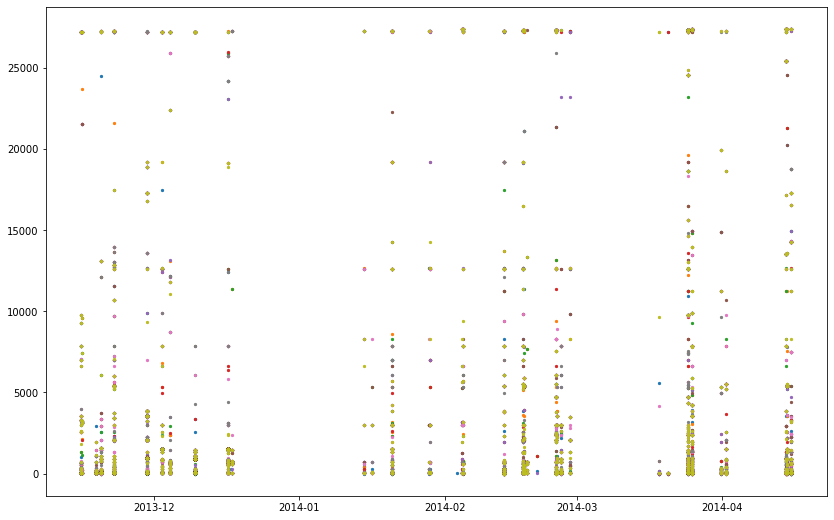

In [13]:
plt.figure(figsize=(14,9))
for i in range(1,10):
    plt.scatter(new_df_train[new_df_train['target']==1]['time'+str(i)],
                new_df_train[new_df_train['target']==1]['site'+str(i)], 
                s=5)

Из графика видно, что Алиса смотрит определённый набор сайтов, а какие-то вообще не смотрит, также видно, что в просмотрах есть определённая цикличность (в какие-то дни Алиса смотрит много сайтов, а в какие-то не сотрит их вовсе). Чтобы проверить наличие цикличности просмотра сайтов построим такой же график для всего датасета.

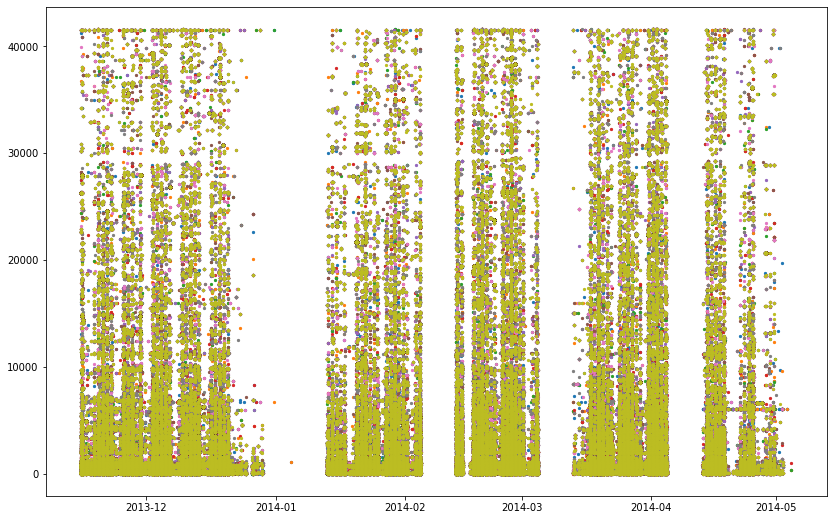

In [14]:
plt.figure(figsize=(14,9))
for i in range(1,10):
    plt.scatter(new_df_train['time'+str(i)],
                new_df_train['site'+str(i)], 
                s=5)

Цикличность просматривается и во всём датасете, возможно это связано с днями недели. Выдели их в датасете.

In [15]:
new_df_train['dayofweek']=pd.DatetimeIndex(new_df_train['time1']).dayofweek
new_df_train.groupby('dayofweek').count()['session_id']

dayofweek
0    41292
1    37784
2    55961
3    37381
4    32278
5     7723
6     3107
Name: session_id, dtype: int64

<BarContainer object of 7 artists>

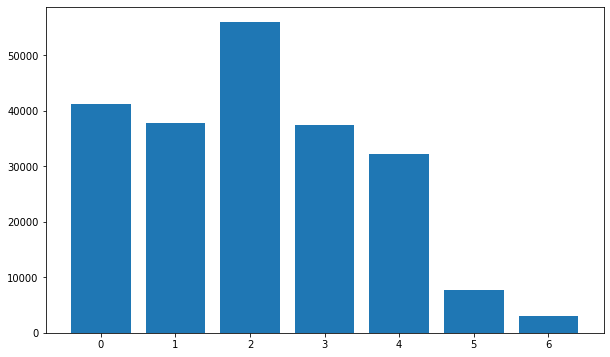

In [16]:
plt.figure(figsize=(10,6))
plt.bar(new_df_train.groupby('dayofweek').count()['session_id'].index,
        height=new_df_train.groupby('dayofweek').count()['session_id'],)

Из полученных результатов видно, что в выходные наблюдается серьёзный спад посещаемости сайтов. Посмотрим есть ли схожая динамика по дням месяца. Рассмотрим как распределяются дни в случаи алисы.

<BarContainer object of 5 artists>

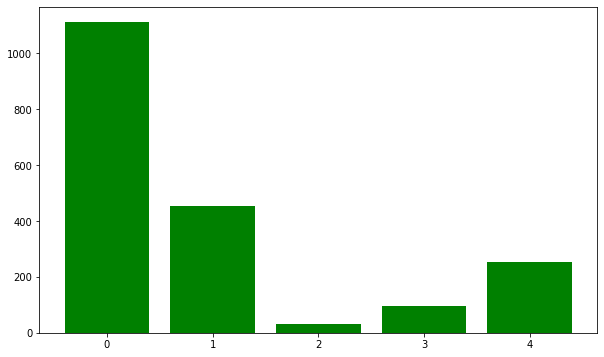

In [17]:
new_df_train_alice = new_df_train[new_df_train['target']==1]

plt.figure(figsize=(10,6))
plt.bar(new_df_train_alice.groupby('dayofweek').count()['session_id'].index,
        height=new_df_train_alice.groupby('dayofweek').count()['session_id'], color='green')

In [18]:
new_df_train_alice['dayofweek']

152       4
286       0
429       3
643       0
681       0
         ..
214960    1
214999    0
215149    0
215502    0
215513    1
Name: dayofweek, Length: 1946, dtype: int64

Распределение у Алисы отличается от общего (в частности Алиса не заходит в интернет по выходным, но в понедельник проводит больше всего времени в сети). Нужно сделать маску для данного столбца и зашифровать дни пропорционально вреоятности, появления Алисы в стеи.

In [19]:
day_of_week_alice = new_df_train_alice.groupby('dayofweek').count()['session_id']
day_of_week_map={}

for i in range(0,7):
    try:
        count_day = day_of_week_alice[i]
    except:
        count_day = 0
        
    day_of_week_map[i] = count_day/np.sum(day_of_week_alice)

В дальнейшем, при подготовки данных примени маску к столбцу с днями недели

In [20]:
#new_df_train['dayofweek'] = new_df_train['dayofweek'].map(day_of_week_map)

In [21]:
new_df_train['day']=pd.DatetimeIndex(new_df_train['time1']).day
new_df_train.groupby('day').count()['session_id']

day
1      6952
2      9612
3      7475
4     11078
5      2710
6      1768
7       115
8       247
9      2929
10     2361
11     2895
12     2013
13     7099
14     6684
15     5129
16     5412
17    11746
18    10149
19    16418
20    11485
21     9775
22     8807
23     2273
24     9648
25    12998
26    14279
27    11516
28     7077
29     6380
30     2148
31     6348
Name: session_id, dtype: int64

<BarContainer object of 31 artists>

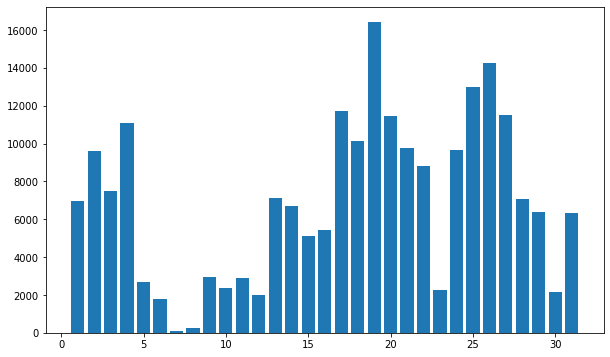

In [22]:
plt.figure(figsize=(10,6))
plt.bar(new_df_train.groupby('day').count()['session_id'].index,
        height=new_df_train.groupby('day').count()['session_id'],)

По графику наблюдается сильный спад в районе 7, 8 числа каждого месяца. Возможно это специфика сбора материала, возможно на это влияют ещё какие-то факторы

Рассмотрим также предпочтительные дни нахождения в сети для Алисы

<BarContainer object of 20 artists>

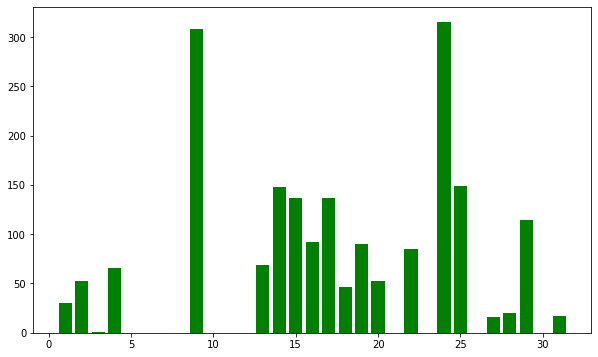

In [23]:
new_df_train_alice = new_df_train[new_df_train['target']==1]

plt.figure(figsize=(10,6))
plt.bar(new_df_train_alice.groupby('day').count()['session_id'].index,
        height=new_df_train_alice.groupby('day').count()['session_id'], color='green')

График нахождения Алисы в интернете также отличается от остальных. В какие-то дни Алиса вообще отсутствует, в другие наоборот заходит чаще чем средний обыватель. Создадим маску для данного столбца

In [24]:
day_alice = new_df_train_alice.groupby('day').count()['session_id']
day_map={}

for i in range(0,32):
    try:
        count_day = day_alice[i]
    except:
        count_day = 0
        
    day_map[i] = count_day/np.sum(day_alice)

Посмотрим как распределена активность пользователей по месяцам

In [25]:
new_df_train['month']=pd.DatetimeIndex(new_df_train['time1']).month
new_df_train['month'].value_counts()

3     47003
2     45202
12    37080
4     35973
11    26457
1     23737
5        74
Name: month, dtype: int64

Посмотрим на посещаемость Алисы

In [26]:
new_df_train_alice = new_df_train[new_df_train['target']==1]
new_df_train_alice['month'].value_counts()

12    506
2     387
11    375
3     346
4     251
1      81
Name: month, dtype: int64

Распределение сессий посещаемости у Алисы отличается от среднего хначения пользователей, в частности, ближе к концу весны количество сессий Алисы уменьшилось. Создадим соответствующую маску

In [27]:
month_alice = new_df_train_alice.groupby('month').count()['session_id']
month_map={}

for i in range(1,13):
    try:
        count_month = month_alice[i]
    except:
        count_month = 0
        
    month_map[i] = (count_month+0.01)/np.sum(month_alice)

In [28]:
month_map

{1: 0.04162898252826311,
 2: 0.19887461459403905,
 3: 0.17780575539568344,
 4: 0.12898766700924974,
 5: 5.138746145940391e-06,
 6: 5.138746145940391e-06,
 7: 5.138746145940391e-06,
 8: 5.138746145940391e-06,
 9: 5.138746145940391e-06,
 10: 5.138746145940391e-06,
 11: 0.19270811921891057,
 12: 0.2600256937307297}

Выделим также часы в рамках каждой сессии и рассмотрим распределение

In [29]:
for i in range(1,10):
    new_df_train['hour'+str(i)] = pd.DatetimeIndex(new_df_train['time1']).hour

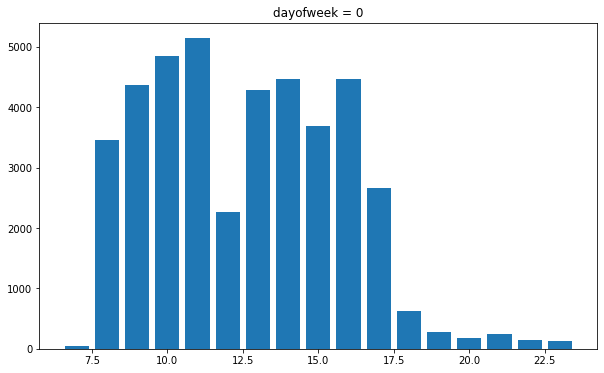

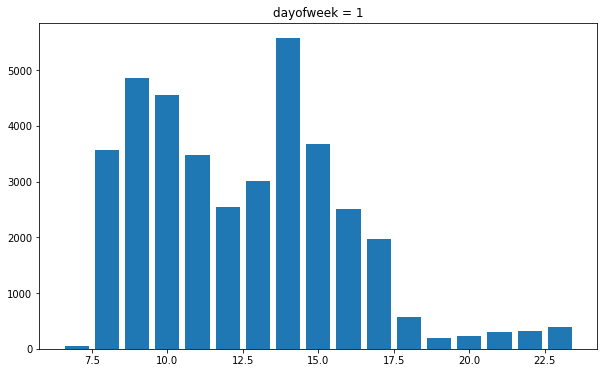

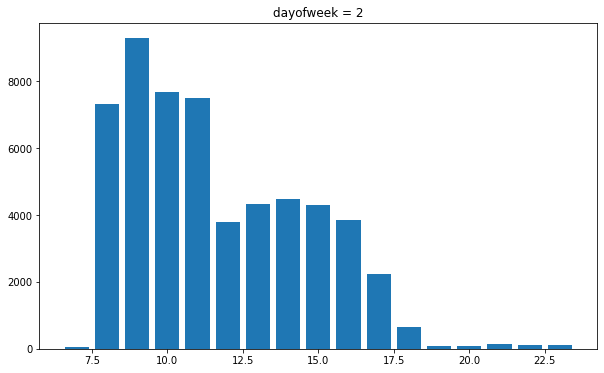

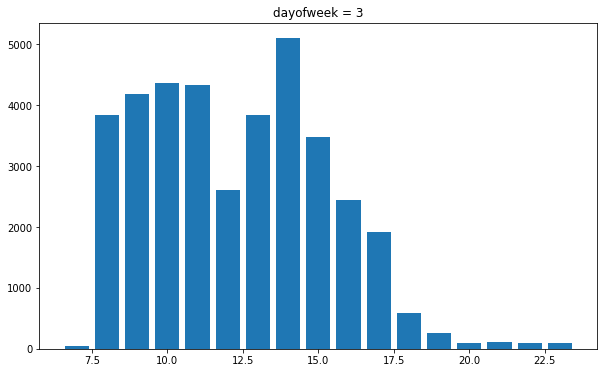

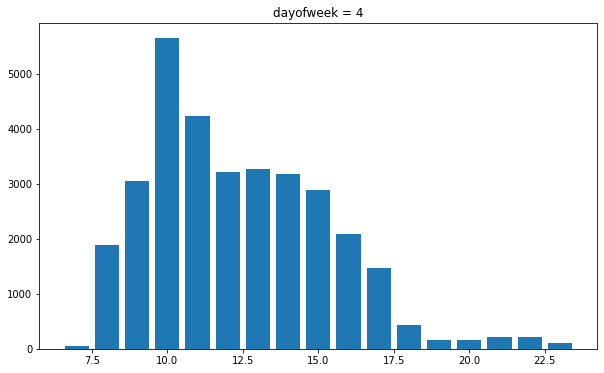

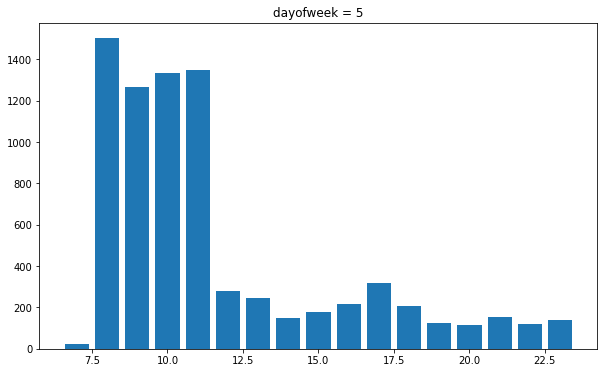

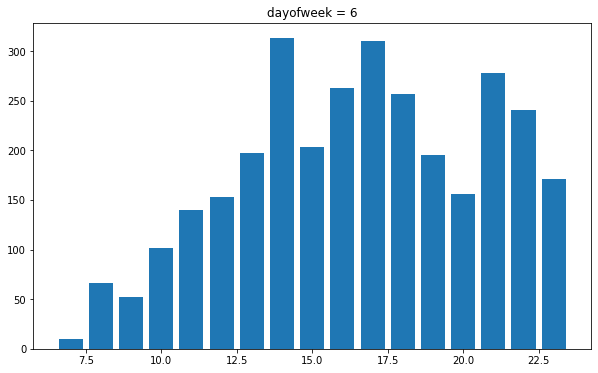

In [30]:
for i in range(0,7):
    plt.figure(figsize=(10,6))
    plt.title('dayofweek = '+str(i))
    data = new_df_train[new_df_train['dayofweek']==i]
    plt.bar(data.groupby('hour1').count()['session_id'].index,
            height=data.groupby('hour1').count()['session_id'])
    plt.show()


Рассмотрим какие часы предпочитает Алиса

Если рассматривать распределение по дням недели, то можно установить, что в будни чаще всего первая сессия начинается в районе 7-8 часов а после 17-18 наблюдается значительный спад. В субботу пик активности приходит на 8-11 часов дня, а в воскресеньке наоброт сессии начинаются в районе 12 часов и не спадают до конца дня.

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_7284\3142803005.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2=new_df_train_alice[new_df_train['dayofweek']==i]


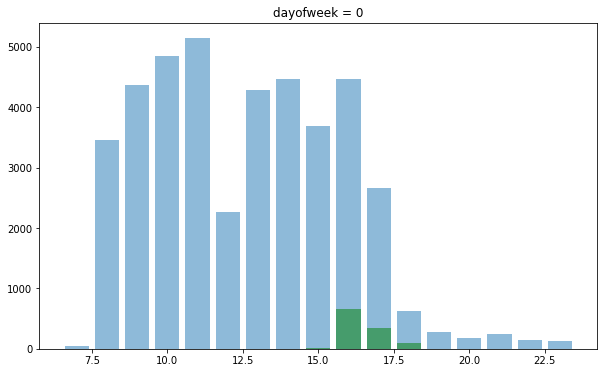

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_7284\3142803005.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2=new_df_train_alice[new_df_train['dayofweek']==i]


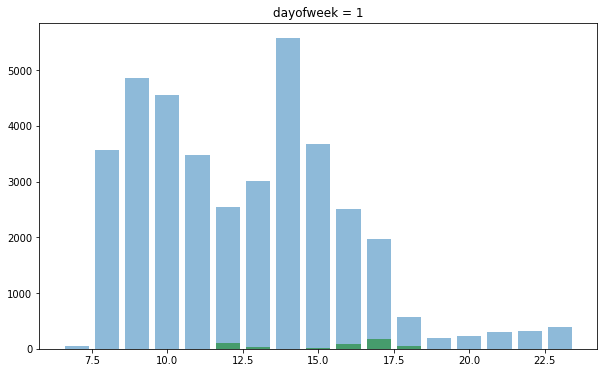

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_7284\3142803005.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2=new_df_train_alice[new_df_train['dayofweek']==i]


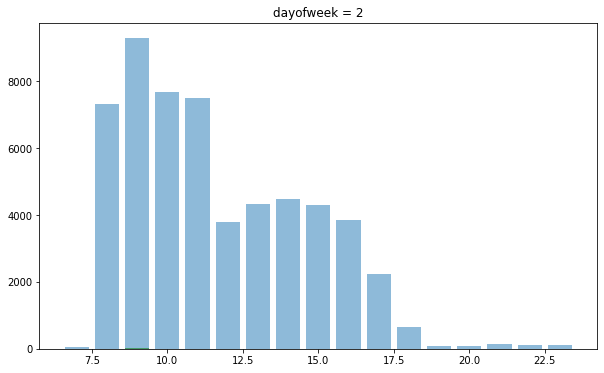

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_7284\3142803005.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2=new_df_train_alice[new_df_train['dayofweek']==i]


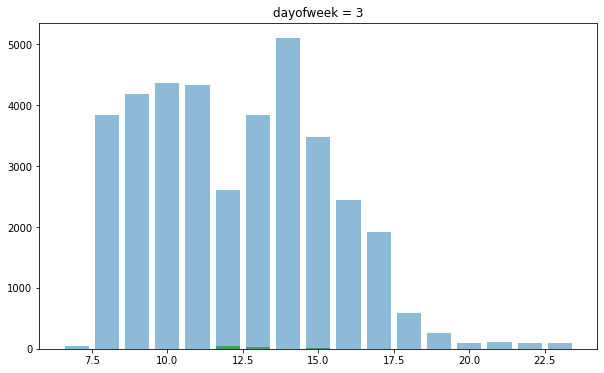

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_7284\3142803005.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2=new_df_train_alice[new_df_train['dayofweek']==i]


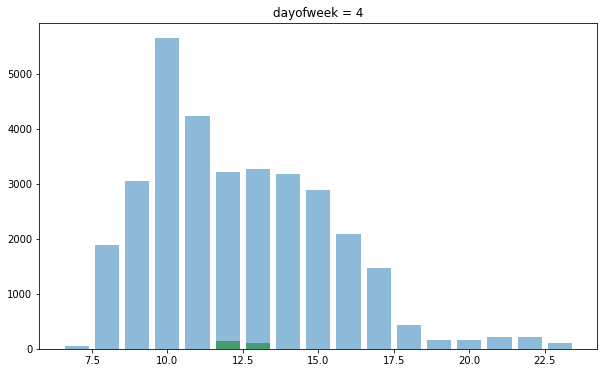

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_7284\3142803005.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2=new_df_train_alice[new_df_train['dayofweek']==i]


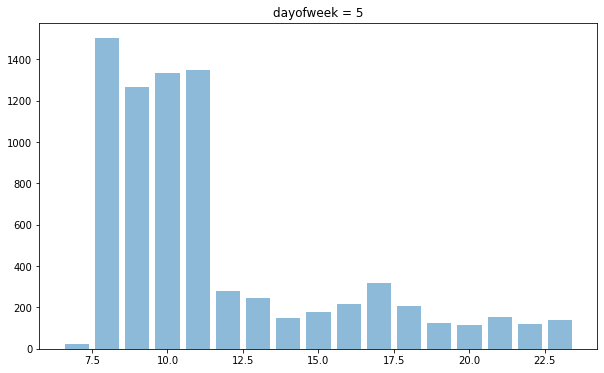

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_7284\3142803005.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2=new_df_train_alice[new_df_train['dayofweek']==i]


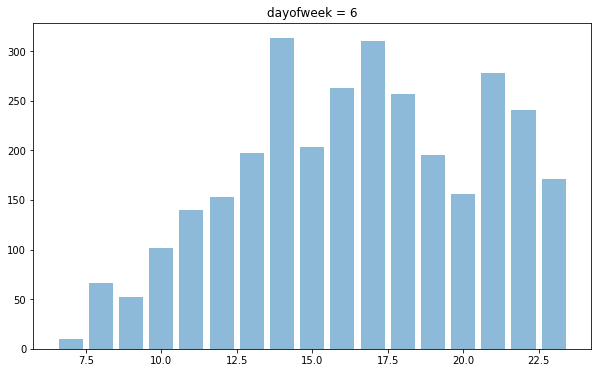

In [31]:
new_df_train_alice = new_df_train[new_df_train['target']==1]

for i in range(0,7):
    plt.figure(figsize=(10,6))
    plt.title('dayofweek = '+str(i))
    data = new_df_train[new_df_train['dayofweek']==i]
    plt.bar(data.groupby('hour1').count()['session_id'].index,
            height=data.groupby('hour1').count()['session_id'], alpha=0.5)
    
    data2=new_df_train_alice[new_df_train['dayofweek']==i]
    plt.bar(data2.groupby('hour1').count()['session_id'].index,
            height=data2.groupby('hour1').count()['session_id'], color='green', alpha=0.5)
    plt.show()

Выведем сводную таблицу по часам для Алисы

In [32]:
new_df_train_alice['hour1'].value_counts()

16    747
17    521
12    286
13    170
18    152
9      33
15     32
14      3
11      2
Name: hour1, dtype: int64

Как видно, алиса предпочитает бывать в интернете в  районе 16-17 часов, реже заходит в 12-18. В данном случае так же создадим маску.

In [33]:
hour_alice = new_df_train_alice.groupby('hour1').count()['session_id']
hour_map={}

for i in range(0,25):
    try:
        count_day = hour_alice[i]
    except:
        count_day = 0
        
    hour_map[i] = count_day/np.sum(hour_alice)

Посичтаем количество сайтов в сессии для каждого сеансаю и выведем сводные значения по данному параметру.

In [34]:
df['count_website'] = 10 - df[time_colomns].isna().sum(axis=1)
a = df['count_website'].value_counts()
a[a.index==10]
len(df['count_website']) - a[a.index==10]

10    22509
Name: count_website, dtype: int64

In [35]:
new_df_train['count_website'] = 10 -new_df_train[time_colomns].isna().sum(axis=1)
new_df_train['count_website'].value_counts()

10    196376
1       2941
2       2674
3       2232
4       2113
5       1994
6       1861
8       1804
7       1794
9       1737
Name: count_website, dtype: int64

Очень многие просматривают все 10 сайтов. Построим диаграмму для всех пользователей и для Алисы отдельно.

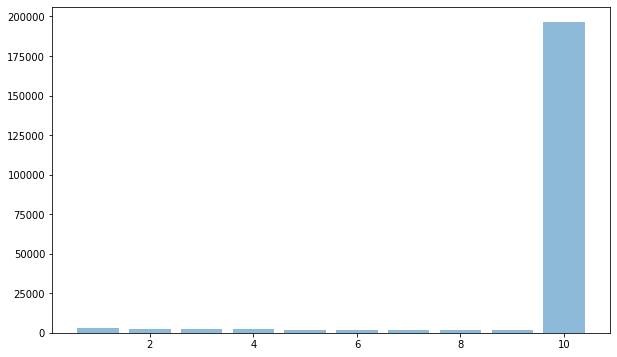

In [36]:
plt.figure(figsize=(10,6))

data2=new_df_train
plt.bar(data2.groupby('count_website').count()['session_id'].index,
        height=data2.groupby('count_website').count()['session_id'],  alpha=0.5)
plt.show()

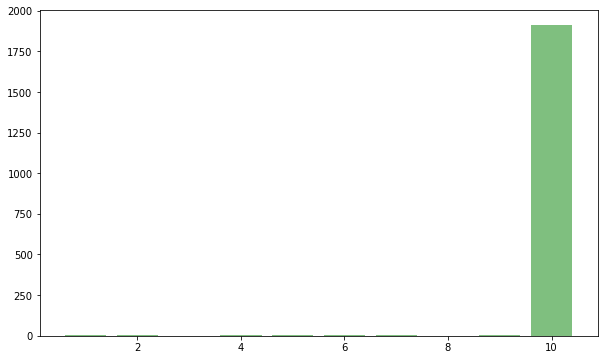

In [37]:
plt.figure(figsize=(10,6))

new_df_train_alice = new_df_train[new_df_train['target']==1]
data2=new_df_train_alice
plt.bar(data2.groupby('count_website').count()['session_id'].index,
        height=data2.groupby('count_website').count()['session_id'], color='green', alpha=0.5)
plt.show()

Среднее распределение данного параметра для Алисы схоже для всех по таблицы, хотя Алиса крайне редко имеет сессии меньше 10 сайтов. Так же сделаем маску для данного параметра на основе данных Алисы.

In [38]:
count_website_alice = new_df_train_alice.groupby('count_website').count()['session_id']
count_website_map={}

for i in range(1,11):
    try:
        count_web = count_website_alice[i]
    except:
        count_web = 0
        
    count_website_map[i] = count_web/np.sum(count_website_alice)

In [39]:
count_website_map

{1: 0.001541623843782117,
 2: 0.0035971223021582736,
 3: 0.0005138746145940391,
 4: 0.0020554984583761563,
 5: 0.003083247687564234,
 6: 0.0020554984583761563,
 7: 0.003083247687564234,
 8: 0.0005138746145940391,
 9: 0.0020554984583761563,
 10: 0.9815005138746146}

Рассмотрим общую продолжительность сессии и построим соответствующие графики

In [40]:
new_df_train['duration'] =  (new_df_train[time_colomns].max(axis=1) - 
                             new_df_train[time_colomns].min(axis=1)).astype('timedelta64[s]')
new_df_train['duration'].value_counts()

2.0       12325
1.0        9317
3.0        8911
4.0        6966
0.0        5675
          ...  
1158.0        1
1351.0        1
1277.0        1
1448.0        1
1552.0        1
Name: duration, Length: 1801, dtype: int64

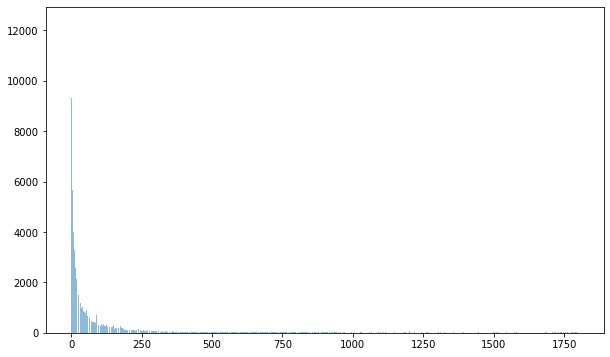

In [41]:
plt.figure(figsize=(10,6))

plt.bar(new_df_train.groupby('duration').count()['session_id'].index,
        height=new_df_train.groupby('duration').count()['session_id'],  alpha=0.5)
plt.show()

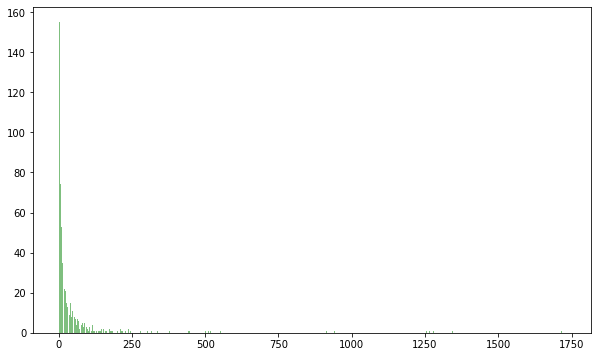

In [42]:
plt.figure(figsize=(10,6))

new_df_train_alice = new_df_train[new_df_train['target']==1]
plt.bar(new_df_train_alice.groupby('duration').count()['session_id'].index,
        height=new_df_train_alice.groupby('duration').count()['session_id'], color='green', alpha=0.5)
plt.show()

Распределения схожие, хотя алиса крайне редко седит больше 250 секунд за сессию из 10 сайтов. Сделаем маску для данного параметра

In [43]:
count_duration_alice = new_df_train_alice.groupby('duration').count()['session_id']
count_duration_map={}

for i in range(0,1801):
    try:
        count_duration = count_duration_alice[i]
    except:
        count_duration = 0
        
    count_duration_map[i] = count_duration/np.sum(count_duration_alice)

Попробуем определить продолжительность сессии на каждой сайте d сессии. Информацию относительно длительности на последнем сайте (10) останется неизвестной, поскольку пользователь мог досидеть до конца или переключиться на следующий сайт раньше.

In [44]:
for i in range(1,10):
    t1='time' + str(i)
    t2='time' + str(i + 1)
    # заполним пропуски в столбцах time, чтобы время отображалось корректно
    new_df_train[t2] = new_df_train[t2].fillna(new_df_train['time1'] + timedelta(minutes=30))
    
    duration_name = 'duration' + str(i)
    new_df_train[duration_name] = (new_df_train[t2] - new_df_train[t1])   

In [45]:
# для работы с графиками выделим из столбца duration секунды. 
for i in range(1, 10):
    new_df_train['duration' + str(i)] = new_df_train['duration' + str(i)].astype('timedelta64[s]')


Сравним среднее время, которое проводит Алиса на сайте со среднестатистическим

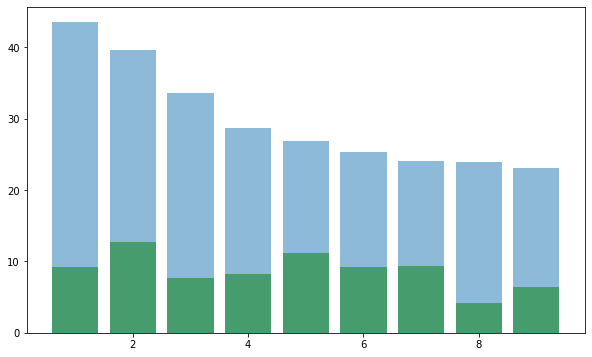

In [46]:
plt.figure(figsize=(10,6))

plt.bar([i for i in range(1,10)],
        height=[new_df_train['duration' + str(i)].mean() for i in range(1,10)],  alpha=0.5)

plt.bar([i for i in range(1,10)],
        height=[new_df_train[new_df_train['target']==1] ['duration' + str(i)].mean() for i in range(1,10)], color='green',  alpha=0.5)
plt.show()

Как видно, Алиса проводит на сайте меньше времени чем другие пользователи

### Создание пайплайна

Для начала выделим из датасетов признаки и цели обучения

In [47]:
target_train = df_train['target']
target_valid = df_valid['target']

feature_train = df_train.drop('target', axis=1)
feature_valid = df_valid.drop('target', axis=1)

Преобразуем данные в столбцах с датами

In [48]:
for t in time_colomns:
    feature_train[t] = pd.to_datetime(feature_train[t])
    feature_valid[t] = pd.to_datetime(feature_valid[t])

Пайплайн должен будет заполнить пропущенные значения, отбросить первый столбец, поскольку идентификатор сессии не информативен с точки зрения использования его в машинном обучении, преобразовать признаки с временем в формат даты и времени, выделить дни недели, дни месяца, часы, удалить старые данные и провести One Hot кодирование дя всех столбцов (поскольку сайты нельзя рассматривать как количественные признаки). 

In [49]:
class DateFrameSelecter (BaseEstimator, TransformerMixin):
  
    def __init__ (self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for_drop_columns = list(set(X.columns) - set(self.attribute_names))
        return X.drop(for_drop_columns, axis=1)

In [50]:
# Доделать то, что не работало с датой
class DateSelector (BaseEstimator, TransformerMixin):
    
    def __init__(self, date_colomns):
        self.date_colomns = date_colomns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        for t in self.date_colomns:
            X[t] = pd.to_datetime(X[t])
       
        t1 = self.date_colomns[0]
        
        X['dayofweek']=pd.DatetimeIndex(X[t1]).dayofweek
        # Применим маску (все маски посчитаны выше)
        X['dayofweek'] = X['dayofweek'].map(day_of_week_map)
        
        X['day']=pd.DatetimeIndex(X[t1]).day
        X['day'] = X['day'].map(day_map)
       
       # добавление месяца в признаки ухудшает качество модели
       # X['month']=pd.DatetimeIndex(X[t1]).month
       # X['month'] = X['month'].map(month_map)
        
        X['hour'] = pd.DatetimeIndex(X[t1]).hour
        X['minute'] = pd.DatetimeIndex(X[t1]).minute
        X['first_time'] = round(X['hour']  + X['minute']/60)
        X['first_time'] = X['first_time'].map(hour_map)        
        X = X.drop(['hour', 'minute'], axis=1)
        
        X['count_website'] = (10 - X[self.date_colomns].isna().sum(axis=1))
        X['count_website'] = X['count_website'].map(count_website_map)
        
        X['duration_all'] = (X[self.date_colomns].max(axis=1)- 
                          X[self.date_colomns].min(axis=1)).astype('timedelta64[s]')
                
        X['duration_all'] = X['duration_all'].map(count_duration_map)
        
        for i in range(1,10):
            t1='time' + str(i)
            t2='time' + str(i + 1)
            # заполним пропуски в столбцах time, чтобы время отображалось корректно
            data[t2] = data[t2].fillna(data['time1'] + timedelta(minutes=30))

            duration_name = 'duration' + str(i)
            data[duration_name] = (data[t2] - data[t1])   
            data[duration_name] = data[duration_name].astype('timedelta64[s]')

                
        return X.drop(self.date_colomns, axis=1)

Отключим оповещения pandas, чтобы не вылазила справочная информаци во время работы с пайплайнами

In [51]:
pd.set_option('mode.chained_assignment', None)

In [52]:
time_colomns = ['time1','time2','time3','time4','time5','time6','time7','time8','time9','time10']
sites = ['site1','site2','site3','site4','site5','site6','site7','site8','site9','site10']
num_colomns = list(set(df_train.columns) - set(sites))

In [53]:
num_pipeline = Pipeline([
                        ('selecter_1', DateFrameSelecter(num_colomns)),
                        ('selecter_2', DateSelector(time_colomns)),
                        ('inputer', SimpleImputer(strategy='constant', fill_value=-1)),
                        ('scaler', StandardScaler())
])

Создадим пайплайн для данной задачи и преобразуем исходные наборы

In [54]:
num_pipeline.fit(feature_train)

Pipeline(steps=[('selecter_1',
                 DateFrameSelecter(attribute_names=['session_id', 'time1',
                                                    'time7', 'time2', 'time5',
                                                    'time3', 'time8', 'target',
                                                    'time4', 'time9', 'time6',
                                                    'time10'])),
                ('selecter_2',
                 DateSelector(date_colomns=['time1', 'time2', 'time3', 'time4',
                                            'time5', 'time6', 'time7', 'time8',
                                            'time9', 'time10'])),
                ('inputer', SimpleImputer(fill_value=-1, strategy='constant')),
                ('scaler', StandardScaler())])

In [55]:
feature_train_num = num_pipeline.transform(feature_train)

In [56]:
feature_valid_num = num_pipeline.transform(feature_valid)

In [57]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)

In [58]:
feature_train[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
feature_valid[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)

In [59]:
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_valid = cv.transform(inp_test_file)

Проверим размеры получившихся матриц

In [60]:
X_train.shape

(215526, 50000)

In [61]:
feature_train_num.shape

(215526, 6)

In [62]:
X_valid.shape

(38035, 50000)

In [63]:
feature_valid_num.shape

(38035, 6)

Объединим получившиеся матрицы в одну

In [64]:
all_feature_train = sp.hstack((X_train, feature_train_num), format='csr')

In [65]:
all_feature_valid = sp.hstack((X_valid, feature_valid_num), format='csr')

## Обучение модели

Обучим разные модели обучения, подберём разные гиперапараметры и выбирем оптимальную. Согласно условию задачи в качестве метрики выступает ROC AUC

### Линейная модель

In [66]:
lin_model = LogisticRegression(random_state=17, solver='lbfgs', max_iter=800)
lin_model.fit(all_feature_train, target_train)
pred_proba = lin_model.predict_proba(all_feature_valid)[:,1]
print('Метрика ROC AUC для логистической регресии равна', roc_auc_score(target_valid, pred_proba))

Метрика ROC AUC для логистической регресии равна 0.9754991349567297


#### Подбор числа сессий

Подберём оптимальное количество числа сессий

In [67]:
opt_i=0
opt_roc=0
for i in notebook.tqdm(range (1,11)):
    cv = CountVectorizer(ngram_range=(1, i), max_features=50000)
    
    feature_train[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
    feature_valid[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)
    
    with open('train_sessions_text.txt') as inp_train_file:
        X_train = cv.fit_transform(inp_train_file)
    with open('test_sessions_text.txt') as inp_test_file:
        X_valid = cv.transform(inp_test_file)
    all_feature_train = sp.hstack((X_train, feature_train_num), format='csr')
    all_feature_valid = sp.hstack((X_valid, feature_valid_num), format='csr')
    
    
    ind = round(all_feature_valid.shape[0]/2)
    all_feature_valid_1 = all_feature_valid[:ind, :]
    target_valid_1 = target_valid[:ind]
    all_feature_valid_2 = all_feature_valid[ind:, :]
    target_valid_2 = target_valid[ind:]
    

    lin_model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=800)
    lin_model.fit(all_feature_train, target_train)
    #pred_proba = lin_model.predict_proba(all_feature_valid)[:,1]
    #print('Количество признаков', i, 'Метрика ROC AUC', roc_auc_score(target_valid, pred_proba))
    pred_proba_1 = lin_model.predict_proba(all_feature_valid_1)[:,1]  
    pred_proba_2 = lin_model.predict_proba(all_feature_valid_2)[:,1]                                
    print('Количество признаков', i, 
          'Метрика ROC AUC_1', roc_auc_score(target_valid_1, pred_proba_1),
         'Метрика ROC AUC_2', roc_auc_score(target_valid_2, pred_proba_2))
    
    mean_roc = (roc_auc_score(target_valid_1, pred_proba_1) + roc_auc_score(target_valid_2, pred_proba_2))/2
    
    if mean_roc>opt_roc:
        opt_roc=mean_roc
        opt_i=i
        
print('Оптимальное количество признаков', opt_i, 'Метрика ROC AUC', opt_roc)

  0%|          | 0/10 [00:00<?, ?it/s]

Количество признаков 1 Метрика ROC AUC_1 0.9768539089723012 Метрика ROC AUC_2 0.9785126623857674
Количество признаков 2 Метрика ROC AUC_1 0.9651776018066012 Метрика ROC AUC_2 0.9730767402917981
Количество признаков 3 Метрика ROC AUC_1 0.9604025326937589 Метрика ROC AUC_2 0.9693105925700212
Количество признаков 4 Метрика ROC AUC_1 0.9618129518108998 Метрика ROC AUC_2 0.9681182959523416
Количество признаков 5 Метрика ROC AUC_1 0.9625366068320016 Метрика ROC AUC_2 0.9661972027854733
Количество признаков 6 Метрика ROC AUC_1 0.9621199370087454 Метрика ROC AUC_2 0.9654714813272093
Количество признаков 7 Метрика ROC AUC_1 0.9625273841007359 Метрика ROC AUC_2 0.9651223187303788
Количество признаков 8 Метрика ROC AUC_1 0.9624381212374138 Метрика ROC AUC_2 0.9648872140514883
Количество признаков 9 Метрика ROC AUC_1 0.9626423388582983 Метрика ROC AUC_2 0.9651600584826383
Количество признаков 10 Метрика ROC AUC_1 0.9623653275370663 Метрика ROC AUC_2 0.9653442843844087
Оптимальное количество призна

Исходя из полученных данных для идентификации Алиcы лучше всего подходит набор из одной сессии создади такие признаки и попробуем ещё улучшить модель

In [68]:
    cv = CountVectorizer(ngram_range=(1, 1), max_features=50000)
    
    feature_train[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
    feature_valid[sites].fillna(0).to_csv('valid_sessions_text.txt', 
                                sep=' ', index=None, header=None)
    
    with open('train_sessions_text.txt') as inp_train_file:
        X_train = cv.fit_transform(inp_train_file)
    with open('valid_sessions_text.txt') as inp_test_file:
        X_valid = cv.transform(inp_test_file)
    all_feature_train = sp.hstack((X_train, feature_train_num), format='csr')
    all_feature_valid = sp.hstack((X_valid, feature_valid_num), format='csr')

#### Подбор коэффициента регуляризации

Попробуем улучшить нашу модель и подберём коэффициент регуляризации, учитывая, что для всего дата сета система не может корректно подобрать значения, будем подбирать только, для признаков времени.

In [69]:
# LogisticRegressionCV не взлетела. Очень долго перебирает параметры и решение не находит. попробуем GridSearchCV
lin = LogisticRegression(solver='lbfgs', max_iter=800, random_state=17)

lin_param = {'C': np.logspace(-1, 2, 50)}

lin_grid = GridSearchCV(lin, 
                         lin_param,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'roc_auc',
                         verbose=True)
lin_grid.fit(all_feature_train, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=800, random_state=17),
             n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.11513954,   0.13257114,   0.1526418 ,
         0.17575106,   0.20235896,   0.23299518,   0.26826958,
         0.30888436,   0.35564803,   0.40949151,   0.47148664,
         0.54286754,   0.62505519,   0.71968567,   0.82864277,
         0.95409548,   1.09854114,   1.26485522,   1.45634848,
         1.67683294,   1.93069773,   2.22299648,   2.55954792,
         2.9470517 ,   3.39322177,   3.90693994,   4.49843267,
         5.17947468,   5.96362332,   6.86648845,   7.90604321,
         9.10298178,  10.48113134,  12.06792641,  13.89495494,
        15.9985872 ,  18.42069969,  21.20950888,  24.42053095,
        28.11768698,  32.37457543,  37.2759372 ,  42.9193426 ,
        49.41713361,  56.89866029,  65.51285569,  75.43120063,
        86.85113738, 100.        ])},
             scoring='roc_auc', verbose=True)

In [70]:
lin_grid.best_params_

{'C': 2.2229964825261943}

Оптимальное значение гиперпараметра C: 2.22

In [71]:
print('Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами', lin_grid.best_score_)

Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами 0.9762537942691324


In [72]:
lin_model = LogisticRegression(C=2.22, random_state=17, solver='lbfgs', max_iter=800,)
lin_model.fit(all_feature_train, target_train)
pred_proba = lin_model.predict_proba(all_feature_valid)[:,1]
print('Метрика ROC AUC для линейной модели на валидационной выборке после подбора uиперпараметра C равен',  roc_auc_score(target_valid, pred_proba))

Метрика ROC AUC для линейной модели на валидационной выборке после подбора uиперпараметра C равен 0.9802065217095468


### Эксперименты с TF-IDF

Попробуем использовать TF-IDF для кодирования сайтов и посмотрим как поменяется качество модели

In [73]:
tf = TfidfVectorizer(ngram_range=(1, 1), max_features=50000)

feature_train[sites].fillna(0).to_csv('tf_train_sessions_text.txt', 
                             sep=' ', index=None, header=None)
feature_valid[sites].fillna(0).to_csv('tf_valid_sessions_text.txt', 
                            sep=' ', index=None, header=None)

with open('tf_train_sessions_text.txt') as inp_train_file:
    X_train = tf.fit_transform(inp_train_file)
with open('tf_valid_sessions_text.txt') as inp_test_file:
    X_valid = tf.transform(inp_test_file)
all_feature_train_tf = sp.hstack((X_train, feature_train_num), format='csr')
all_feature_valid_tf = sp.hstack((X_valid, feature_valid_num), format='csr')

In [74]:
lin_model = LogisticRegression(random_state=17, solver='lbfgs', max_iter=800)
lin_model.fit(all_feature_train_tf, target_train)
pred_proba = lin_model.predict_proba(all_feature_valid_tf)[:,1]
print('Метрика ROC AUC для логистической регресии равна', roc_auc_score(target_valid, pred_proba))

Метрика ROC AUC для логистической регресии равна 0.9731181868959174


С базовыми настройками логистическая регрессия даёт лучшие показатели при испольщовании TfidfVectorize чем при CountVectorizer. 

#### Подбор числа сессий для TF-IDF

In [75]:
opt_i=0
opt_roc=0
for i in notebook.tqdm(range (1,11)):
    tf = TfidfVectorizer(ngram_range=(1, i), max_features=50000)
    
    feature_train[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
    feature_valid[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)
    
    with open('train_sessions_text.txt') as inp_train_file:
        X_train = tf.fit_transform(inp_train_file)
    with open('test_sessions_text.txt') as inp_test_file:
        X_valid = tf.transform(inp_test_file)
    all_feature_train = sp.hstack((X_train, feature_train_num), format='csr')
    all_feature_valid = sp.hstack((X_valid, feature_valid_num), format='csr')
    
    
    ind = round(all_feature_valid.shape[0]/2)
    all_feature_valid_1 = all_feature_valid[:ind, :]
    target_valid_1 = target_valid[:ind]
    all_feature_valid_2 = all_feature_valid[ind:, :]
    target_valid_2 = target_valid[ind:]
    

    lin_model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=800)
    lin_model.fit(all_feature_train, target_train)
    #pred_proba = lin_model.predict_proba(all_feature_valid)[:,1]
    #print('Количество признаков', i, 'Метрика ROC AUC', roc_auc_score(target_valid, pred_proba))
    pred_proba_1 = lin_model.predict_proba(all_feature_valid_1)[:,1]  
    pred_proba_2 = lin_model.predict_proba(all_feature_valid_2)[:,1]                                
    print('Количество признаков', i, 
          'Метрика ROC AUC_1', roc_auc_score(target_valid_1, pred_proba_1),
         'Метрика ROC AUC_2', roc_auc_score(target_valid_2, pred_proba_2))
    
    mean_roc = (roc_auc_score(target_valid_1, pred_proba_1) + roc_auc_score(target_valid_2, pred_proba_2))/2
    
    if mean_roc>opt_roc:
        opt_roc=mean_roc
        opt_i=i
        
print('Оптимальное количество признаков', opt_i, 'Метрика ROC AUC', opt_roc)

  0%|          | 0/10 [00:00<?, ?it/s]

Количество признаков 1 Метрика ROC AUC_1 0.9832261575104159 Метрика ROC AUC_2 0.9809749715554089
Количество признаков 2 Метрика ROC AUC_1 0.9741378146145376 Метрика ROC AUC_2 0.9802520456343493
Количество признаков 3 Метрика ROC AUC_1 0.9746819557592169 Метрика ROC AUC_2 0.9771867390897172
Количество признаков 4 Метрика ROC AUC_1 0.9759010032025934 Метрика ROC AUC_2 0.9766625758638908
Количество признаков 5 Метрика ROC AUC_1 0.9773117517029938 Метрика ROC AUC_2 0.9762563843080906
Количество признаков 6 Метрика ROC AUC_1 0.9773232801170759 Метрика ROC AUC_2 0.9761954415970344
Количество признаков 7 Метрика ROC AUC_1 0.9774306590596701 Метрика ROC AUC_2 0.9760553851830938
Количество признаков 8 Метрика ROC AUC_1 0.977379604654449 Метрика ROC AUC_2 0.9758739548185278
Количество признаков 9 Метрика ROC AUC_1 0.9774270358438157 Метрика ROC AUC_2 0.9759642506702298
Количество признаков 10 Метрика ROC AUC_1 0.9773301971655253 Метрика ROC AUC_2 0.97588821205827
Оптимальное количество признаков

Для TF-IDF оптимальным оказалось количество сессий равным 1. 

In [83]:
tf = TfidfVectorizer(ngram_range=(1, 1), max_features=50000)

feature_train[sites].fillna(0).to_csv('tf_train_sessions_text.txt', 
                             sep=' ', index=None, header=None)
feature_valid[sites].fillna(0).to_csv('tf_valid_sessions_text.txt', 
                            sep=' ', index=None, header=None)

with open('tf_train_sessions_text.txt') as inp_train_file:
    X_train = tf.fit_transform(inp_train_file)
with open('tf_valid_sessions_text.txt') as inp_test_file:
    X_valid = tf.transform(inp_test_file)
all_feature_train_tf = sp.hstack((X_train, feature_train_num), format='csr')
all_feature_valid_tf = sp.hstack((X_valid, feature_valid_num), format='csr')

#### Подбор коэффициента регуляризации

Подберём коэффициент регурелизации при помощи GridSearchCV

In [84]:
lin = LogisticRegression(solver='lbfgs', max_iter=800, random_state=17)

lin_param = {'C': np.logspace(-1, 2, 50)}

lin_grid = GridSearchCV(lin, 
                         lin_param,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'roc_auc',
                         verbose=True)
lin_grid.fit(all_feature_train_tf, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=800, random_state=17),
             n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.11513954,   0.13257114,   0.1526418 ,
         0.17575106,   0.20235896,   0.23299518,   0.26826958,
         0.30888436,   0.35564803,   0.40949151,   0.47148664,
         0.54286754,   0.62505519,   0.71968567,   0.82864277,
         0.95409548,   1.09854114,   1.26485522,   1.45634848,
         1.67683294,   1.93069773,   2.22299648,   2.55954792,
         2.9470517 ,   3.39322177,   3.90693994,   4.49843267,
         5.17947468,   5.96362332,   6.86648845,   7.90604321,
         9.10298178,  10.48113134,  12.06792641,  13.89495494,
        15.9985872 ,  18.42069969,  21.20950888,  24.42053095,
        28.11768698,  32.37457543,  37.2759372 ,  42.9193426 ,
        49.41713361,  56.89866029,  65.51285569,  75.43120063,
        86.85113738, 100.        ])},
             scoring='roc_auc', verbose=True)

In [85]:
print('Оптимальное значение гиперпарамета', lin_grid.best_params_)

Оптимальное значение гиперпарамета {'C': 18.420699693267164}


In [86]:
print('Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами и TF-IDF', lin_grid.best_score_)

Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами и TF-IDF 0.9770861687947583


Проведём более тонкую настройку коэффициента регуляризации в диапазоне от 16 до 21

In [87]:
lin = LogisticRegression(solver='lbfgs', max_iter=800, random_state=17)

lin_param = {'C': np.arange(16, 21, 0.5)}

lin_grid = GridSearchCV(lin, 
                         lin_param,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'roc_auc',
                         verbose=True)
lin_grid.fit(all_feature_train_tf, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=800, random_state=17),
             n_jobs=-1,
             param_grid={'C': array([16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5])},
             scoring='roc_auc', verbose=True)

In [88]:
print('Оптимальное значение гиперпарамета', lin_grid.best_params_)

Оптимальное значение гиперпарамета {'C': 20.5}


In [89]:
print('Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами и TF-IDF', lin_grid.best_score_)

Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами и TF-IDF 0.9770908712500697


Проведём более тонкую настройку коэффициента регуляризации в диапазоне от 20 до 21

In [91]:
lin = LogisticRegression(solver='lbfgs', max_iter=800, random_state=17)

lin_param = {'C': np.arange(20, 21, 0.05)}

lin_grid = GridSearchCV(lin, 
                         lin_param,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'roc_auc',
                         verbose=True)
lin_grid.fit(all_feature_train_tf, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=800, random_state=17),
             n_jobs=-1,
             param_grid={'C': array([20.  , 20.05, 20.1 , 20.15, 20.2 , 20.25, 20.3 , 20.35, 20.4 ,
       20.45, 20.5 , 20.55, 20.6 , 20.65, 20.7 , 20.75, 20.8 , 20.85,
       20.9 , 20.95])},
             scoring='roc_auc', verbose=True)

In [92]:
print('Оптимальное значение гиперпарамета', lin_grid.best_params_)
print('Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами и TF-IDF', lin_grid.best_score_)

Оптимальное значение гиперпарамета {'C': 20.300000000000004}
Метрика ROC AUC для линейной модели на кросвалидации с оптимальными параметрами и TF-IDF 0.9770920634831282


In [94]:
lin_model = LogisticRegression(C=20.3, random_state=17, solver='lbfgs', max_iter=800,)
lin_model.fit(all_feature_train_tf, target_train)
pred_proba = lin_model.predict_proba(all_feature_valid_tf)[:,1]
print('Метрика ROC AUC для линейной модели на валидационной выборке после подбора uиперпараметра C равен',  roc_auc_score(target_valid, pred_proba))

Метрика ROC AUC для линейной модели на валидационной выборке после подбора uиперпараметра C равен 0.9820680053139452


### Проверка на тестовой выборке

#### CountVectorizer

Для начала обучим модель на всей выборке

In [101]:
cv = CountVectorizer(ngram_range=(1, 1), max_features=50000)
df = pd.read_csv('train.csv')
target_train = df['target']
feature_train = df.drop('target', axis=1)

feature_train_num = num_pipeline.fit_transform(feature_train)
feature_train[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
all_feature_train = sp.hstack((X_train, feature_train_num), format='csr')

final_model = LogisticRegression(C=2.2, random_state=17, solver='lbfgs', max_iter=800)
final_model.fit(all_feature_train, target_train)

LogisticRegression(C=2.2, max_iter=800, random_state=17)

Преобразуем данные тестовой выборки и сделаем предсказания

In [102]:
feature_test = pd.read_csv('test.csv')

feature_test_num = num_pipeline.transform(feature_test)
feature_test[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
all_feature_test = sp.hstack((X_test, feature_test_num), format='csr')
all_feature_test.shape
pred_proba = final_model.predict_proba(all_feature_test)[:,1]

Запишем ответы в файл

In [103]:
predicted_df = pd.DataFrame(pred_proba,
                                index = range(1, pred_proba.shape[0] + 1),
                                columns=['target'])

predicted_df.to_csv('baseline.csv', index_label="session_id")

#### TF-IDF

Аналогично поступим с моделью данные для которой кодировались при помощи TF-IDF

In [105]:
tf = TfidfVectorizer(ngram_range=(1, 1), max_features=50000)
df = pd.read_csv('train.csv')
target_train = df['target']
feature_train = df.drop('target', axis=1)

feature_train_num = num_pipeline.fit_transform(feature_train)
feature_train[sites].fillna(0).to_csv('tf_train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
with open('tf_train_sessions_text.txt') as inp_train_file:
    X_train = tf.fit_transform(inp_train_file)
all_feature_train = sp.hstack((X_train, feature_train_num), format='csr')

final_model = LogisticRegression(C=20.3, random_state=17, solver='lbfgs', max_iter=800)
final_model.fit(all_feature_train, target_train)

LogisticRegression(C=20.3, max_iter=800, random_state=17)

In [106]:
feature_test = pd.read_csv('test.csv')

feature_test_num = num_pipeline.transform(feature_test)
feature_test[sites].fillna(0).to_csv('tf_test_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
with open('tf_test_sessions_text.txt') as inp_test_file:
    X_test = tf.transform(inp_test_file)
all_feature_test = sp.hstack((X_test, feature_test_num), format='csr')

pred_proba = final_model.predict_proba(all_feature_test)[:,1]

In [107]:
predicted_df = pd.DataFrame(pred_proba,
                                index = range(1, pred_proba.shape[0] + 1),
                                columns=['target'])

predicted_df.to_csv('baseline_tf.csv', index_label="session_id")

## Выводы

В данной работе нами были проанализированы исходные данные поведения Алисы. Были изучены предпочтения по разным дням, когда Алиса чаще появляется в сети. По данным видно, что поведение Алисы меняется с течением времени. Данные по сайтамбыли закодированы сначала при помощи CountVectorizer, затем при помощи TF-IDF.
Лучший результат получилса модель данные для которой кодировались с применением TF-IDF и без использования месяца в качестве признака (на тестовой выборке public_score оказался равен 0,945615). 